# Data mining techniques: Assignment 2

## Exploratory Data Analysis

In [1]:
library("ggplot2")
library("scales")
library("plyr")
library("corrplot")

# Not sure if used
#library("grid")
#library("gridExtra")

Warning message:
“package ‘ggplot2’ was built under R version 3.4.4”Warning message:
“package ‘scales’ was built under R version 3.4.4”Warning message:
“package ‘plyr’ was built under R version 3.4.4”Warning message:
“package ‘corrplot’ was built under R version 3.4.4”corrplot 0.84 loaded
Warning message:
“package ‘gbm’ was built under R version 3.4.4”Loading required package: survival
Loading required package: lattice
Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.3


# Load the data

In [2]:
# Memory efficient column specific data frame loading functions
col_list <- function(names,selected,df){
    "
    Creates a list from a data.frame with specified column 
    classes and a vector with specified column names
    "
    
    res <- c(1:length(names))
    res[] <- "NULL"
        
    for(i in 1:length(selected)){
        res[names == selected[i]] <- df[selected[i],1]
    }
    
    return(res)
}

load_part <- function(path,nrows = -1,skip = 1,colClasses = NA){
    "Loads the specified column names from a csv file into a data.frame"
    
    namecols <- colClasses
    if(length(namecols) > 1 || !is.na(namecols)){
        namecols[colClasses != "NULL"] <- NA
    }
    
    names <- colnames(read.csv(trainPath,nrows = 1,colClasses=namecols))
    df <- read.csv(trainPath,header=F,skip=skip,nrows = nrows,colClasses=colClasses,
                   na.strings=c("NA","NULL"))
    
    colnames(df) <- names
    
    return(df)
}

In [3]:
trainPath <- "/home/kevin/data_mining/data/assignment2/initial_train.csv"
testPath <- "/home/kevin/data_mining/data/assignment2/final_test.csv"

trainNames <- colnames(read.csv(trainPath,nrows = 1))
testNames <- colnames(read.csv(testPath,nrows = 1))

# Initialize types to numeric
traintypes <- c(1:length(trainNames))
traintypes[] <- "numeric"

# Initialize type dataframe
train.types <- data.frame(types=traintypes,stringsAsFactors=FALSE)
rownames(train.types) <- trainNames

# Set types manually
train.types["date_time","types"] <- "character"

train.types

,types
srch_id,numeric
date_time,character
site_id,numeric
visitor_location_country_id,numeric
visitor_hist_starrating,numeric
visitor_hist_adr_usd,numeric
prop_country_id,numeric
prop_id,numeric
prop_starrating,numeric
prop_review_score,numeric


In [4]:
# Example
attributes <- c("srch_id","comp1_rate")
columns <- col_list(trainNames,attributes,train.types)
load_part(trainPath,nrows = 5,colClasses = columns)

srch_id,comp1_rate
1,NA
1,NA
1,NA
1,NA
1,NA


# Initial data exploration

## Plot missing values

In [5]:
attributes <- trainNames
columns <- col_list(trainNames,attributes,train.types)
df <- load_part(trainPath,colClasses = columns)

# Get NA value booleans
nas <- is.na(df)

len.nas <- length(nas[,1])

# Initialize NA vector
na.vec <- vector(mode="integer",length=length(colnames(df)))

# Sum the NA values and fill NA vector
for (i in 1:length(na.vec)){
    na.vec[i] <- sum(nas[,i]) / len.nas
}

# Create bar plot Data Frame
na.df <- data.frame(colnames(df),na.vec)
colnames(na.df) <- c("attribute","missing_values")

# Sort by number of missing values
position <- arrange(na.df,missing_values)["attribute"][,1]

    srch_id        date_time            site_id      
 Min.   :     1   Length:4958347     Min.   : 1.000  
 1st Qu.: 82936   Class :character   1st Qu.: 5.000  
 Median :166507   Mode  :character   Median : 5.000  
 Mean   :166367                      Mean   : 9.953  
 3rd Qu.:249724                      3rd Qu.:14.000  
 Max.   :332785                      Max.   :34.000  
                                                     
 visitor_location_country_id visitor_hist_starrating visitor_hist_adr_usd
 Min.   :  1.0               Min.   :1               Min.   :   0        
 1st Qu.:100.0               1st Qu.:3               1st Qu.: 110        
 Median :219.0               Median :3               Median : 152        
 Mean   :175.3               Mean   :3               Mean   : 176        
 3rd Qu.:219.0               3rd Qu.:4               3rd Qu.: 213        
 Max.   :231.0               Max.   :5               Max.   :1959        
                             NA's   :4706481      

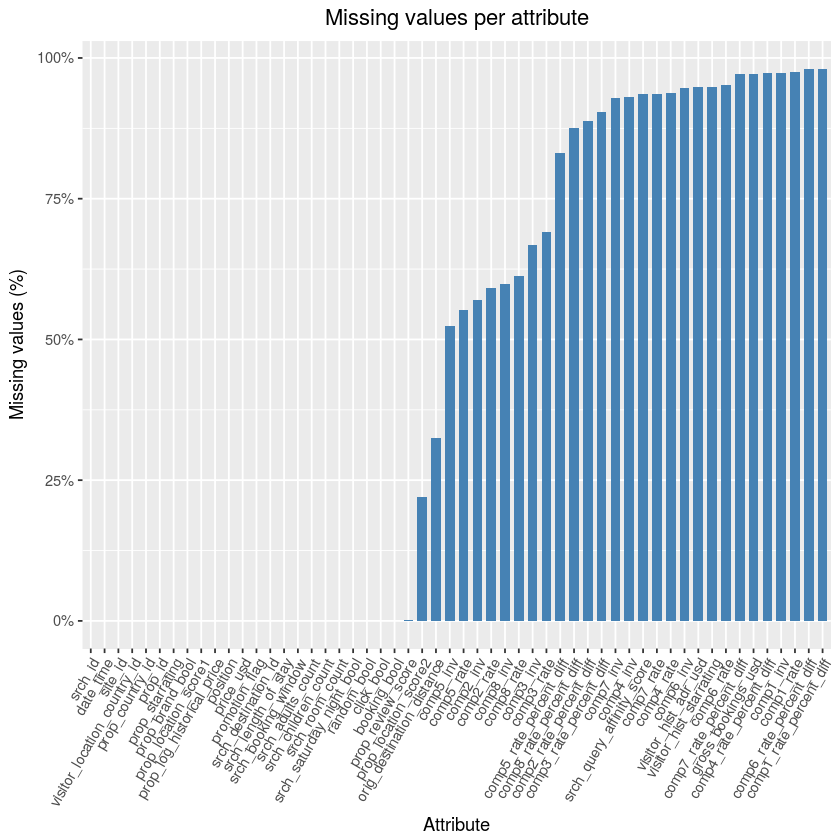

In [6]:
# Plot missing values bar plot
ggplot(data=na.df,aes(x=factor(attribute),y=missing_values)) + 
geom_bar(stat="identity",width=0.7, fill="steelblue") +
theme(axis.text.x = element_text(angle = 60, hjust = 1), plot.title = element_text(hjust = 0.5)) + 
scale_x_discrete(limits=position) + scale_y_continuous(labels=percent) +
labs(title="Missing values per attribute", x="Attribute", y="Missing values (%)")

summary(df)

# Exploratory data analysis: Investigate Missing Values

## Competitor attributes

In [7]:
comp_data <- function(df,attr_name){
    "Returns competitor data for bookings and clicks"
    
    booked <- df[,"booking_bool"] == 1
    clicked <- df[,"click_bool"] == 1

    books <- data.frame()
    clicks <- data.frame()

    for (i in c(1:8)){
        str <- sprintf("comp%i_%s",i,attr_name)
        
        # Full value counts
        full <- as.data.frame(table(df[,str], useNA="always"))
    
        full[,"Competitor"] <- factor(i,levels=c(1:8))
    
        full[,"Var1"] <- factor(full[,"Var1"],levels=c(-1,0,1,"NA"))
        full[is.na(full[,"Var1"]),"Var1"] <- factor("NA",levels=c(-1,0,1,"NA"))
    
        # Booked value counts
        book <- as.data.frame(table(df[booked,str], useNA="always"))
    
        book[,"Competitor"] <- factor(i,levels=c(1:8))
    
        book[,"Var1"] <- factor(book[,"Var1"],levels=c(-1,0,1,"NA"))
        book[is.na(book[,"Var1"]),"Var1"] <- factor("NA",levels=c(-1,0,1,"NA"))
    
        book[,"Freq"] <- book[,"Freq"] / full[,"Freq"]
    
        # Click value counts
        click <- as.data.frame(table(df[clicked,str], useNA="always"))
        
        click[,"Competitor"] <- factor(i,levels=c(1:8))
    
        click[,"Var1"] <- factor(click[,"Var1"],levels=c(-1,0,1,"NA"))
        click[is.na(click[,"Var1"]),"Var1"] <- factor("NA",levels=c(-1,0,1,"NA"))
    
        click[,"Freq"] <- click[,"Freq"] / full[,"Freq"]
    
        books <- rbind(books,book)
        clicks <- rbind(clicks,click)
    }
    
    return(list(books,clicks))
}

### Competitor rates

In [8]:
attributes <- c(sprintf("comp%i_rate",1:8),"booking_bool","click_bool")
columns <- col_list(trainNames,attributes,train.types)
df <- load_part(trainPath,colClasses = columns)

data <- comp_data(df,"rate")

books <- data[[1]]
clicks <- data[[2]]

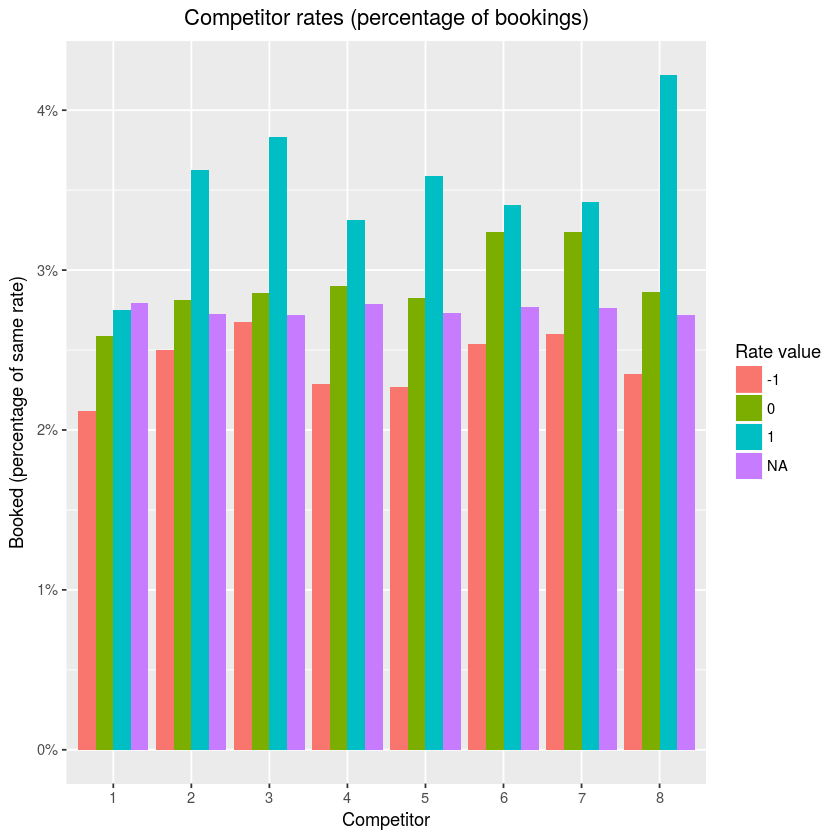

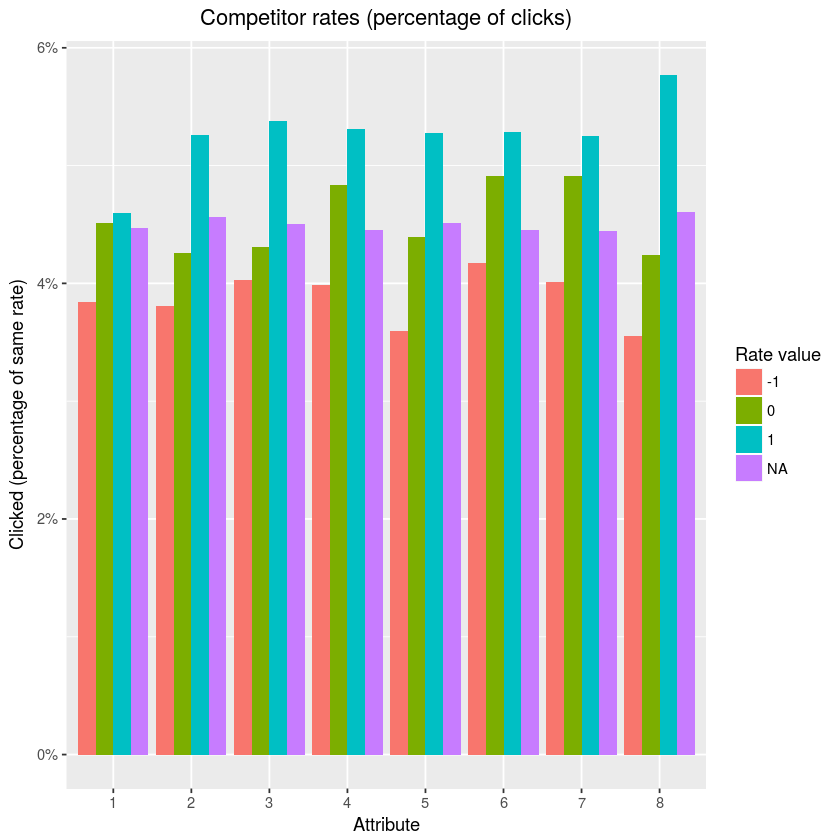

In [9]:
ggplot(data=books, aes(x=Competitor,y=Freq,fill=Var1)) +
geom_bar(stat="identity",position=position_dodge()) + scale_y_continuous(labels=percent) +
theme(plot.title = element_text(hjust = 0.5)) + 
labs(title="Competitor rates (percentage of bookings)", x="Competitor", y="Booked (percentage of same rate)",
     fill="Rate value")

ggplot(data=clicks, aes(x=Competitor,y=Freq,fill=Var1)) +
geom_bar(stat="identity",position=position_dodge()) + scale_y_continuous(labels=percent) +
theme(plot.title = element_text(hjust = 0.5)) + 
labs(title="Competitor rates (percentage of clicks)", x="Attribute", y="Clicked (percentage of same rate)",
     fill="Rate value")

### Competitor inv

In [22]:
attributes <- c(sprintf("comp%i_inv",1:8),"booking_bool","click_bool")
columns <- col_list(trainNames,attributes,train.types)
df <- load_part(trainPath,colClasses = columns)

data <- comp_data(df,"inv")

books <- data[[1]]
clicks <- data[[2]]

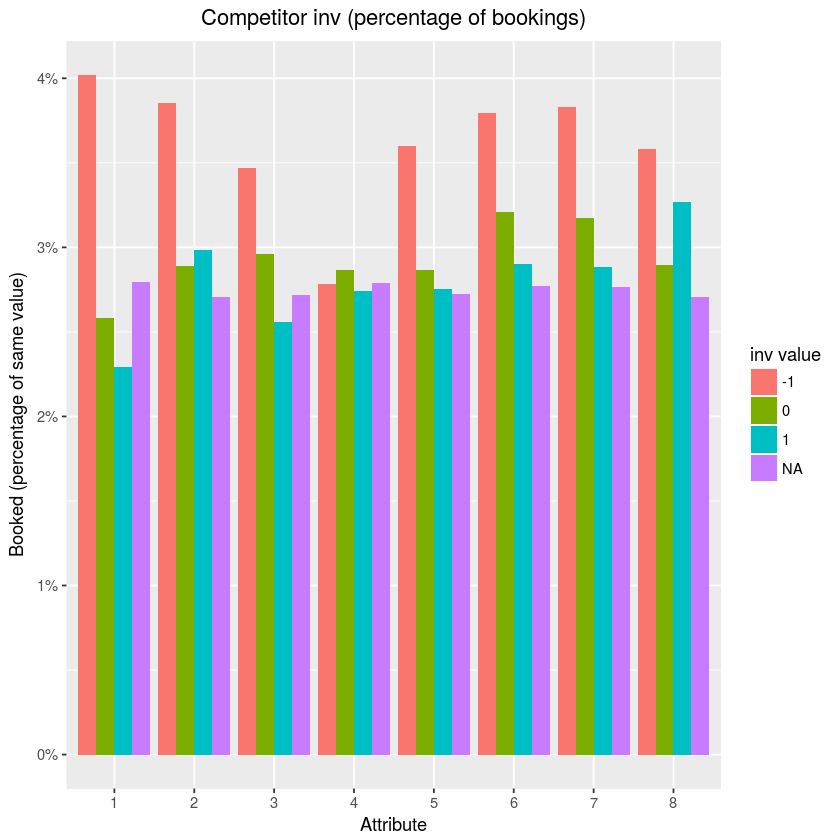

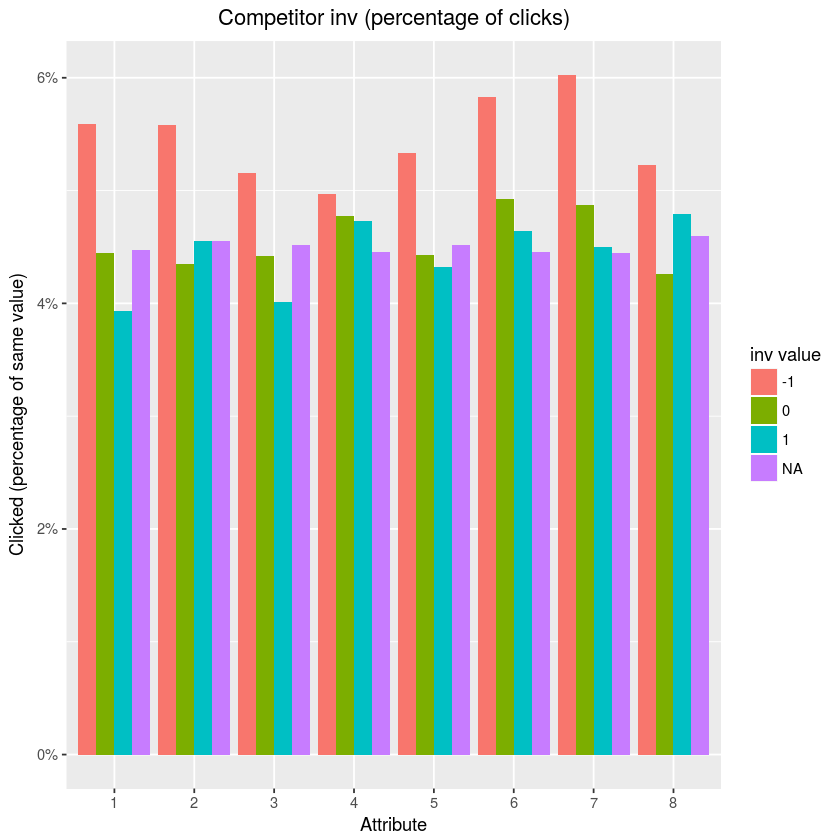

In [24]:
ggplot(data=books, aes(x=Competitor,y=Freq,fill=Var1)) +
geom_bar(stat="identity",position=position_dodge()) + scale_y_continuous(labels=percent) +
theme(plot.title = element_text(hjust = 0.5)) + 
labs(title="Competitor inv (percentage of bookings)", x="Attribute", y="Booked (percentage of same value)",
     fill="inv value")

ggplot(data=clicks, aes(x=Competitor,y=Freq,fill=Var1)) +
geom_bar(stat="identity",position=position_dodge()) + scale_y_continuous(labels=percent) +
theme(plot.title = element_text(hjust = 0.5)) + 
labs(title="Competitor inv (percentage of clicks)", x="Attribute", y="Clicked (percentage of same value)",
     fill="inv value")

## Descriptive hotel attributes (description for customers)

In [16]:
na_booking_data <- function(df,attr_name){
    "
    Returns the number of NA values for 
    an attribute for both books and clicks
    "
    
    booked <- df[,"booking_bool"] == 1
    clicked <- df[,"click_bool"] == 1
    
    nas.full <- is.na(df[,attr_name])
    nas.book <- nas.full[booked]
    nas.click <- nas.full[clicked]
    
    labels <- c("Not NA","NA")
    
    book.ratio.na <- sum(nas.book) / sum(nas.full)
    book.ratio.nna <- sum(!nas.book) / sum(!nas.full)
    
    click.ratio.na <- sum(nas.click) / sum(nas.full)
    click.ratio.nna <- sum(!nas.click) / sum(!nas.full)
    
    # Booked value counts
    books <- data.frame(target_attribute="booking_bool",attribute=attr_name,var=labels,
                        ratio = c(book.ratio.nna,book.ratio.na))

    # Click value counts
    clicks <- data.frame(target_attribute="click_bool",attribute=attr_name,var=labels,
                        ratio = c(click.ratio.nna,click.ratio.na))
    
    result <- rbind(books,clicks)
    return(result)
}

In [17]:
attributes <- c("prop_review_score","prop_location_score2",
                "srch_query_affinity_score","booking_bool","click_bool")
columns <- col_list(trainNames,attributes,train.types)
df <- load_part(trainPath,colClasses = columns)

hotel.df <- rbind(na_booking_data(df,"prop_review_score"),
                  na_booking_data(df,"prop_location_score2"),
                  na_booking_data(df,"srch_query_affinity_score"))

books <- hotel.df[hotel.df[,"target_attribute"] == "booking_bool",]
clicks <- hotel.df[hotel.df[,"target_attribute"] == "click_bool",]

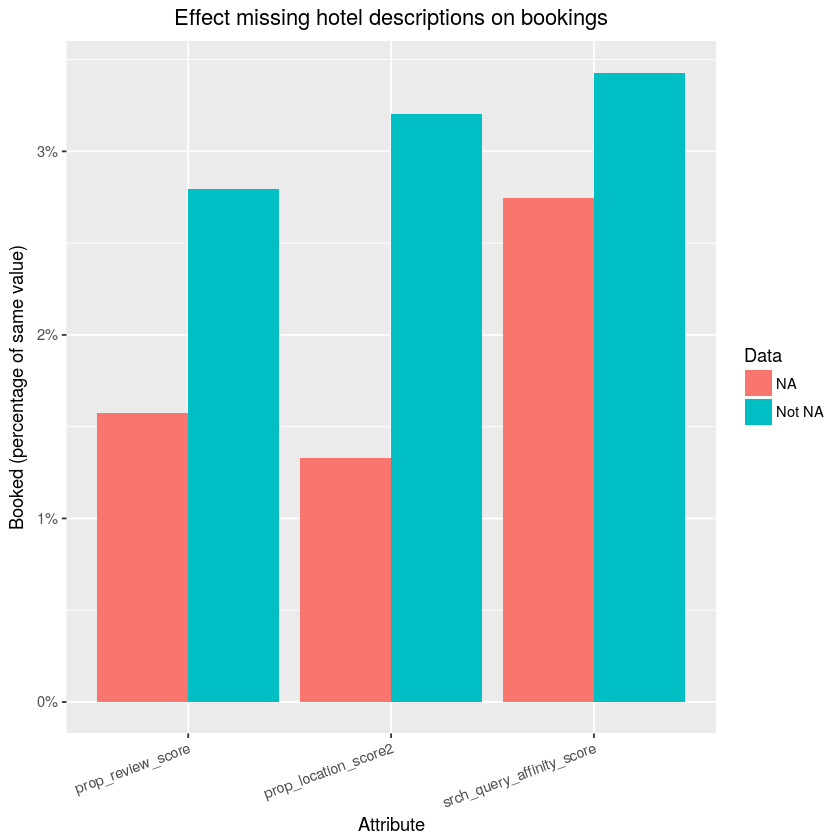

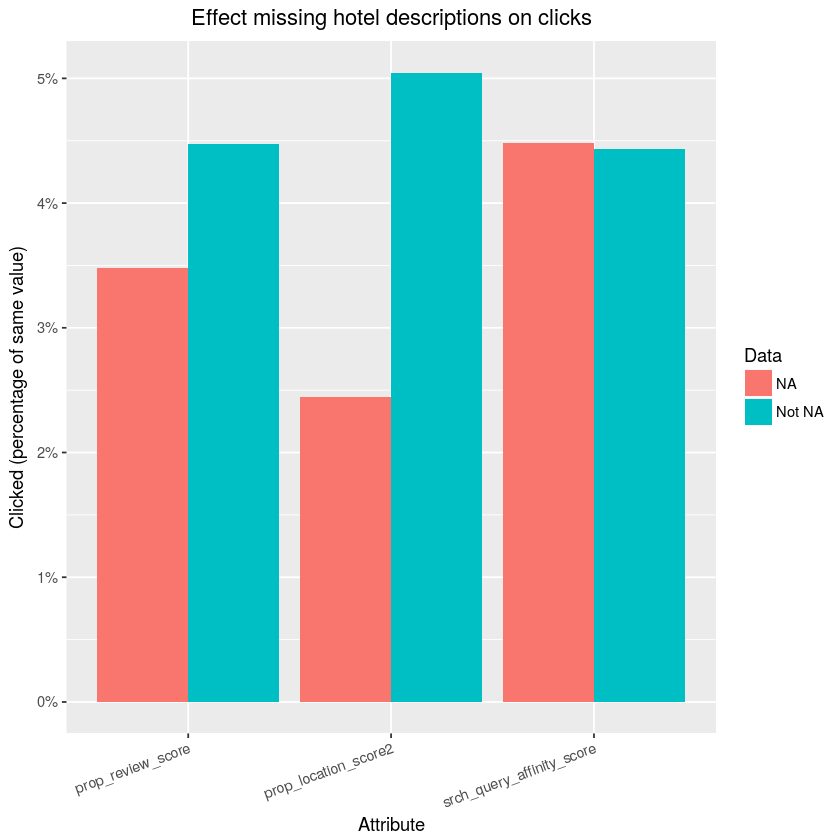

In [18]:
ggplot(data=books, aes(x=attribute,y=ratio,fill=var)) +
geom_bar(stat="identity",position=position_dodge()) + scale_y_continuous(labels=percent) +
theme(axis.text.x = element_text(angle = 20, hjust = 1), plot.title = element_text(hjust = 0.5)) +
labs(title="Effect missing hotel descriptions on bookings", x="Attribute", y="Booked (percentage of same value)",
     fill="Data")

ggplot(data=clicks, aes(x=attribute,y=ratio,fill=var)) +
geom_bar(stat="identity",position=position_dodge()) + scale_y_continuous(labels=percent) +
theme(axis.text.x = element_text(angle = 20, hjust = 1), plot.title = element_text(hjust = 0.5)) +
labs(title="Effect missing hotel descriptions on clicks", x="Attribute", y="Clicked (percentage of same value)",
     fill="Data")

## Origin-destination distance

In [19]:
attributes <- c("orig_destination_distance","booking_bool","click_bool")
columns <- col_list(trainNames,attributes,train.types)
df <- load_part(trainPath,colClasses = columns)

distance.df <- na_booking_data(df,"orig_destination_distance")

books <- distance.df[distance.df[,"target_attribute"] == "booking_bool",]
clicks <- distance.df[distance.df[,"target_attribute"] == "click_bool",]

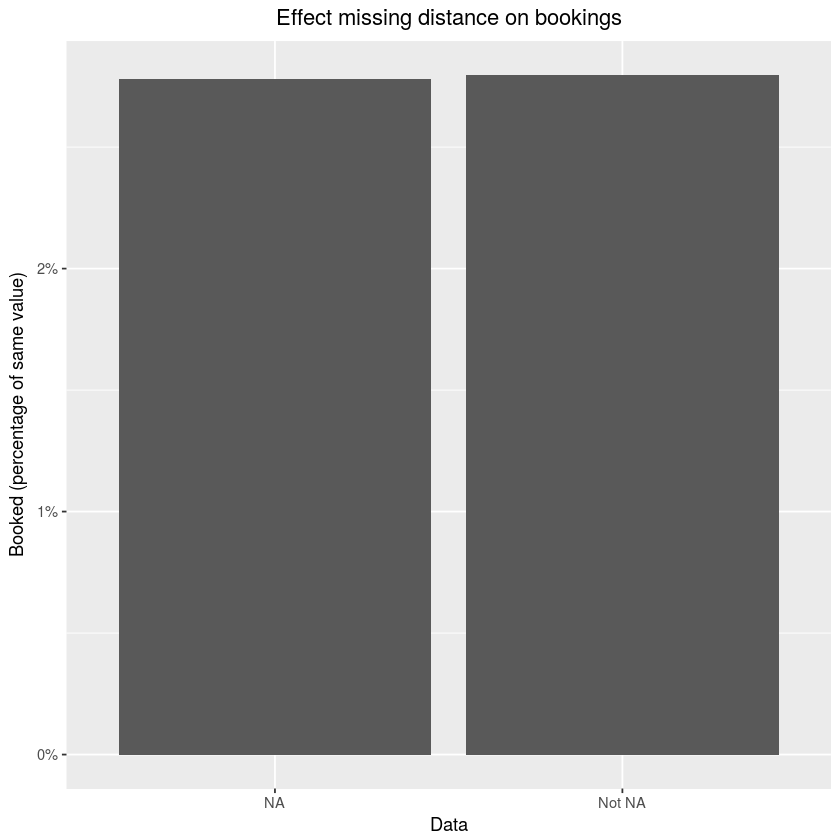

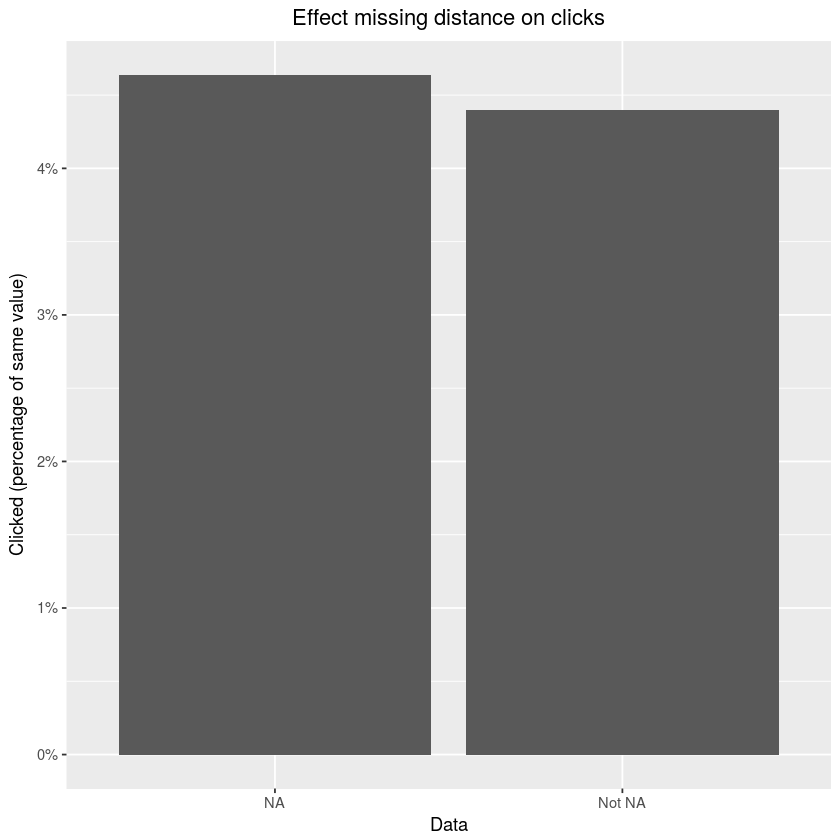

In [20]:
ggplot(data=books, aes(x=var,y=ratio)) +
geom_bar(stat="identity",position=position_dodge()) + scale_y_continuous(labels=percent) +
theme(plot.title = element_text(hjust = 0.5)) +
labs(title="Effect missing distance on bookings", x="Data", y="Booked (percentage of same value)")

ggplot(data=clicks, aes(x=var,y=ratio)) +
geom_bar(stat="identity",position=position_dodge()) + scale_y_continuous(labels=percent) +
theme(plot.title = element_text(hjust = 0.5)) +
labs(title="Effect missing distance on clicks", x="Data", y="Clicked (percentage of same value)")

Warning message:
“Removed 1607782 rows containing non-finite values (stat_bin).”

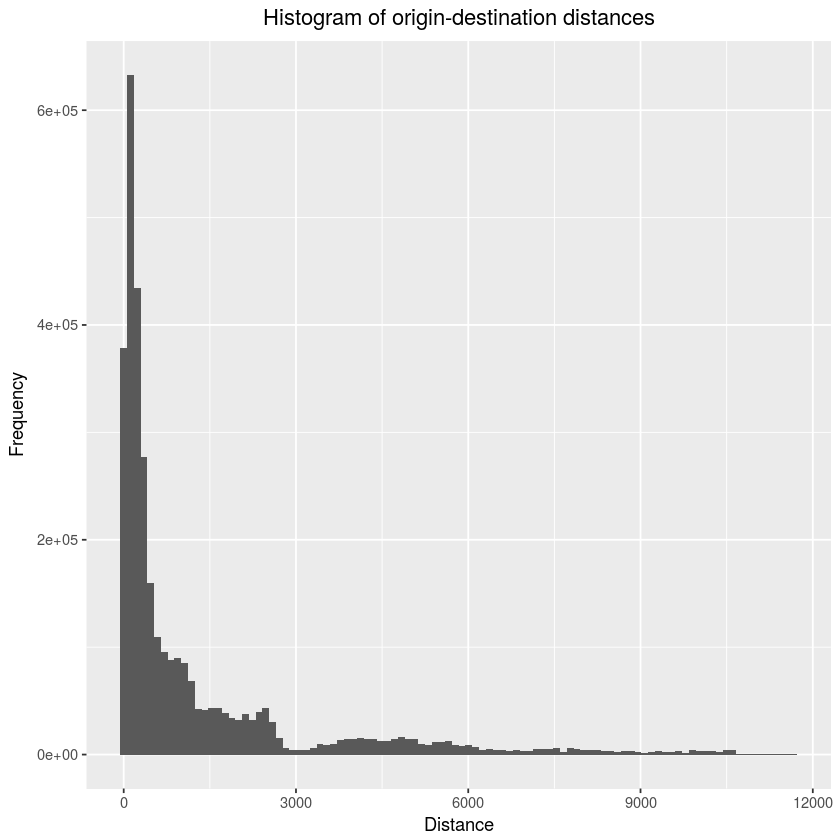

In [21]:
ggplot(data=df, aes(x=orig_destination_distance, na.rm=TRUE)) +
geom_bar(stat="bin",bins=100) + theme(plot.title = element_text(hjust = 0.5)) +
labs(title="Histogram of origin-destination distances", x="Distance", y="Frequency")

# Exploratory data analysis: Feature Relations

# Exploratory data analysis: Feature Importance

## Plot something

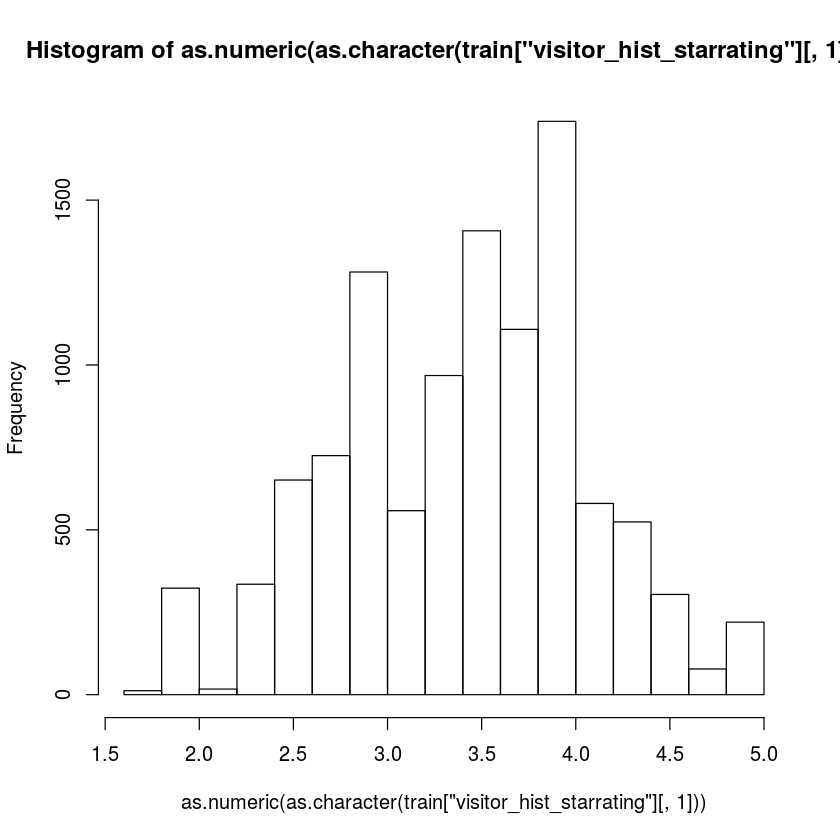

In [168]:
#ggplot(data=train,aes(x=visitor_hist_starrating)) + geom_histogram(bins=30)
hist(as.numeric(as.character(train["visitor_hist_starrating"][,1])))

## Correlation plot of the numeric attributes

In [5]:
impTrainPath <- "/home/kevin/data_mining/data/assignment2/split_data_dm/mod_train.csv"
impTrainNames <- colnames(read.csv(impTrainPath,nrows = 1))

df <- read.csv(impTrainPath,colClasses=rep("numeric",length(impTrainNames)))

In [6]:
head(df)

colnames(df)

srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,⋯,date_year,starrating_diff,usd_diff,price_rank,star_rank,relevance,room_count,persons_count,ignored_bool,prop_starrating_monotonic
49766,5,219,NA,NA,219,10827,0,4.0,1,⋯,2013,0,0,2,4,0,522,18,1,3.3130997
49766,5,219,NA,NA,219,33591,4,4.0,1,⋯,2013,0,0,14,1,0,522,18,1,0.6869003
49766,5,219,NA,NA,219,43888,3,4.0,1,⋯,2013,0,0,7,2,0,522,18,1,0.3130997
49766,5,219,NA,NA,219,46317,3,3.5,1,⋯,2013,0,0,6,2,0,522,18,1,0.3130997
49766,5,219,NA,NA,219,47864,4,4.0,0,⋯,2013,0,0,16,1,0,522,18,1,0.6869003
49766,5,219,NA,NA,219,48913,3,4.0,1,⋯,2013,0,0,14,2,0,522,18,1,0.3130997


[1] "srch_id"                     "site_id"                    
 [3] "visitor_location_country_id" "visitor_hist_starrating"    
 [5] "visitor_hist_adr_usd"        "prop_country_id"            
 [7] "prop_id"                     "prop_starrating"            
 [9] "prop_review_score"           "prop_brand_bool"            
[11] "prop_location_score1"        "prop_location_score2"       
[13] "prop_log_historical_price"   "position"                   
[15] "price_usd"                   "promotion_flag"             
[17] "srch_destination_id"         "srch_length_of_stay"        
[19] "srch_booking_window"         "srch_adults_count"          
[21] "srch_children_count"         "srch_room_count"            
[23] "srch_saturday_night_bool"    "srch_query_affinity_score"  
[25] "orig_destination_distance"   "random_bool"                
[27] "comp1_rate"                  "comp1_inv"                  
[29] "comp1_rate_percent_diff"     "comp2_rate"                 
[31] "comp2_inv"                   "comp2_rate_percent_diff"    
[33] "comp3_rate"                  "comp3_inv"                  
[35] "comp3_rate_percent_diff"     "comp4_rate"                 
[37] "comp4_inv"                   "comp4_rate_percent_diff"    
[39] "comp5_rate"                  "comp5_inv"                  
[41] "comp5_rate_percent_diff"     "comp6_rate"                 
[43] "comp6_inv"                   "comp6_rate_percent_diff"    
[45] "comp7_rate"                  "comp7_inv"                  
[47] "comp7_rate_percent_diff"     "comp8_rate"                 
[49] "comp8_inv"                   "comp8_rate_percent_diff"    
[51] "click_bool"                  "gross_bookings_usd"         
[53] "booking_bool"                "date_hour"                  
[55] "date_month"                  "date_year"                  
[57] "starrating_diff"             "usd_diff"                   
[59] "price_rank"                  "star_rank"                  
[61] "relevance"                   "room_count"                 
[63] "persons_count"               "ignored_bool"               
[65] "prop_starrating_monotonic"

In [ ]:
df.nums <- subset(df,select=c(-gross_bookings_usd,-visitor_hist_starrating,-visitor_hist_adr_usd))

rm(df)

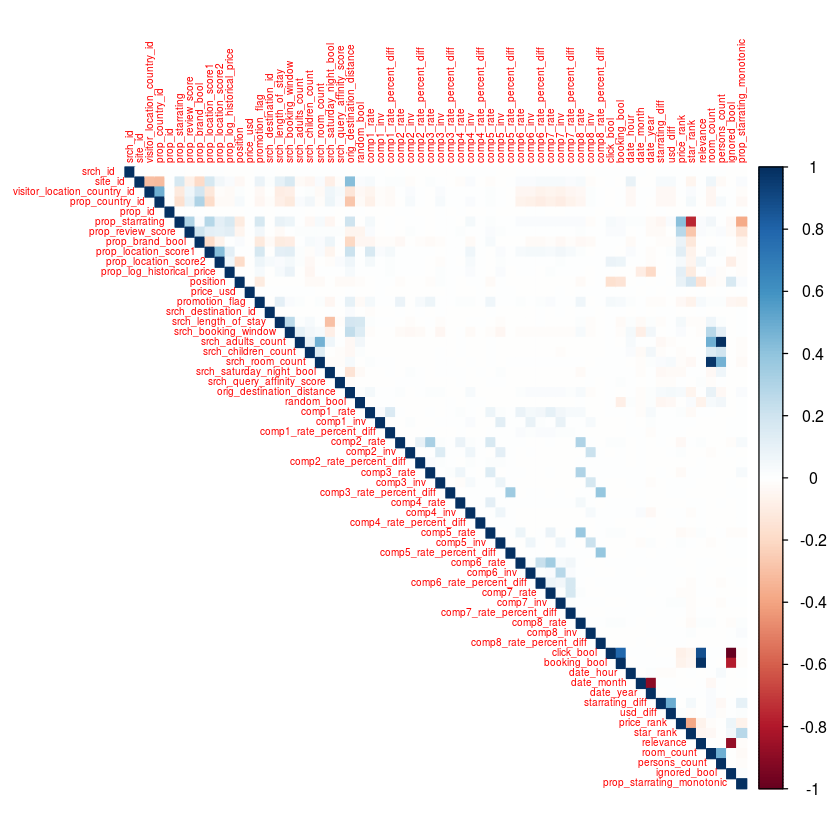

In [8]:
# type = "upper"
corrplot(cor(df.nums),method="color",type="upper",tl.cex=0.5)